In [17]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import precision_recall_fscore_support
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import seaborn as sns


# Elementary Data Analysis

In [2]:
trn = pd.read_csv('glitch_trn_data.csv')
label=pd.read_csv('glitch_trn_class_labels.csv',names=["D_value","Type"])
dataset=pd.concat([trn,label],axis=1)
dataset=dataset.dropna().drop("D_value",axis=1).drop("id",axis=1)
print(dataset.head(10))
dataset.count()


        GPStime  centralFreq  peakFreq       snr ifo    bandwidth  duration  \
0  1.129517e+09      364.822   225.349    35.919  L1   665.643311     0.250   
1  1.135647e+09     3609.954    38.027  2743.555  H1  7209.994629    13.690   
2  1.129802e+09     1838.466  2025.310    16.698  H1  3612.932861     0.375   
3  1.131774e+09     2067.878   111.128    12.727  H1  4067.436523     0.105   
4  1.130969e+09     3978.111   131.921    10.926  L1  7795.106934     2.304   
5  1.128233e+09      809.473    99.067   203.265  H1  1554.946655     1.813   
6  1.133965e+09      824.968   324.754    61.062  L1  1594.804199     0.375   
7  1.127496e+09      555.868   111.062     7.637  H1   992.661682     0.078   
8  1.133070e+09      294.661   137.711    27.163  L1   521.001648     0.313   
9  1.127725e+09      247.280   149.414    27.835  H1   430.560944     0.219   

             Type  
0            Blip  
1  Extremely_Loud  
2     Violin_Mode  
3            Blip  
4        Scratchy  
5        K

GPStime        6000
centralFreq    6000
peakFreq       6000
snr            6000
ifo            6000
bandwidth      6000
duration       6000
Type           6000
dtype: int64

In [3]:
import warnings
warnings.filterwarnings('ignore')

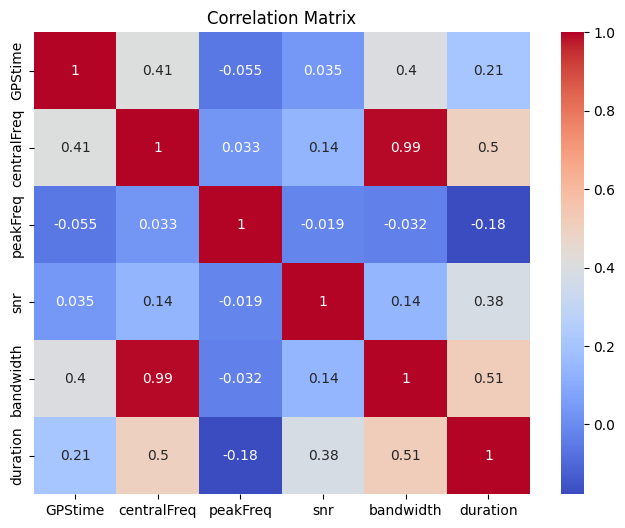

In [6]:
correlation_matrix = dataset.drop(["ifo","Type"],axis=1).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [10]:
label["Type"].value_counts()

Type
Blip                   1587
Koi_Fish                638
Low_Frequency_Burst     474
Low_Frequency_Lines     445
Power_Line              405
Extremely_Loud          403
Scattered_Light         384
Light_Modulation        360
Helix                   243
Scratchy                242
None_of_the_Above       136
Whistle                 131
Violin_Mode             123
Tomte                    84
Repeating_Blips          82
1400Ripples              75
Chirp                    54
Air_Compressor           51
No_Glitch                37
Paired_Doves             23
Wandering_Line           19
1080Lines                 4
Name: count, dtype: int64

In [11]:
label.isnull().sum()

D_value    0
Type       0
dtype: int64

In [12]:
dataset.isnull().sum()

GPStime        0
centralFreq    0
peakFreq       0
snr            0
ifo            0
bandwidth      0
duration       0
Type           0
dtype: int64

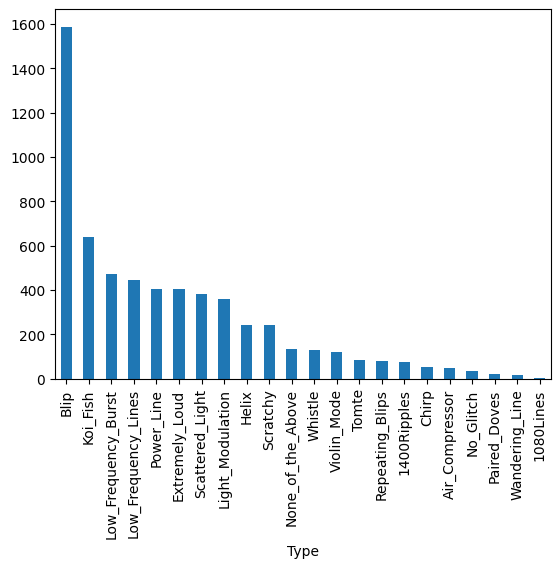

In [13]:
label["Type"].value_counts().plot(kind="bar")
plt.savefig("glitch distribution.png", bbox_inches='tight')

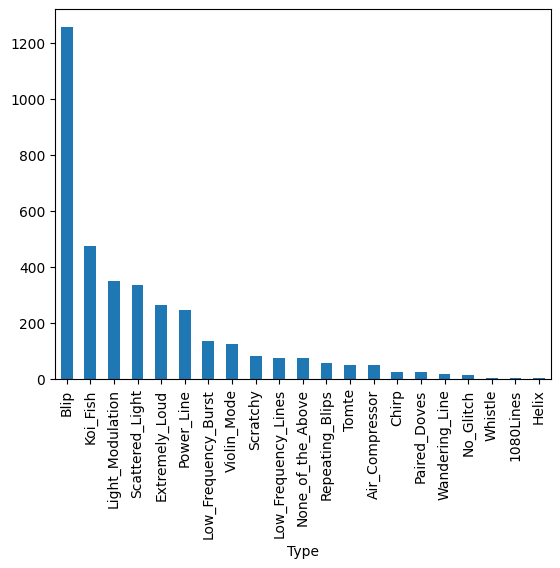

In [16]:
dataset_h1=dataset[dataset['ifo']=='H1']
dataset_h1["Type"].value_counts().plot(kind="bar")
plt.savefig("glitch distribution H1.png",  facecolor='w')

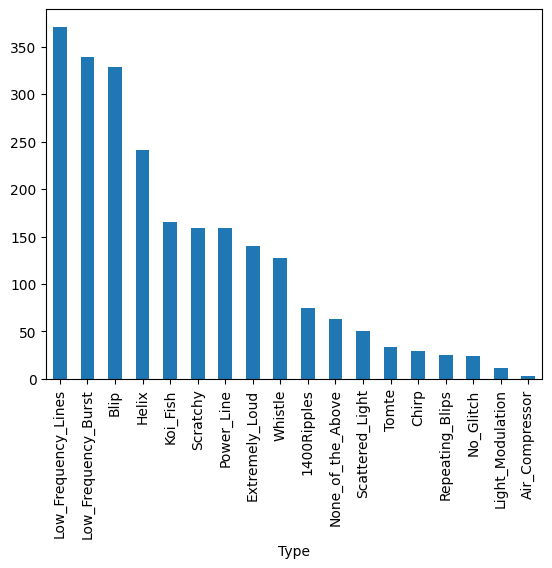

In [14]:
dataset_l1=dataset[dataset['ifo']=='L1']
dataset_l1["Type"].value_counts().plot(kind="bar")
plt.savefig("glitch distribution L1.png")

In [15]:
df1=dataset.drop("ifo",axis=1)

# Grid Search For various Classifiers

## Without ifo

In [6]:
#Gridsearch after removing ifo
df1=dataset.drop("ifo",axis=1)

X = df1.drop(["Type","GPStime"],axis=1)
y = df1["Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=50)

models = [
    DecisionTreeClassifier(random_state=50),
    RandomForestClassifier(random_state=50),
    KNeighborsClassifier(),
    linear_model.LogisticRegression(multi_class='multinomial',random_state=50),
]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'Before gridsearch, Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}')

    scoring = ['precision_macro', 'recall_macro', 'f1_macro']
    param_grid = {}
    if type(model).__name__ == 'DecisionTreeClassifier':
        param_grid = {
            'criterion': ['gini', 'entropy','log_loss'],
            'max_depth': [9, 10, 11, None],
            'min_samples_split': [9,10,11]
        }
    elif type(model).__name__ == 'RandomForestClassifier':
        param_grid = {'n_estimators': [80,100,130],
            'criterion': ['gini', 'entropy'],
            'max_depth': [19, 20,21, None],
            'min_samples_split': [2,3,4]
        }
    elif type(model).__name__ == 'LogisticRegression':
        param_grid = {
            'C': [90,100,110],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'newton-cg','liblinear'],
            'max_iter': [100, 200, 1000]
        }
    elif type(model).__name__ == 'KNeighborsClassifier':
        param_grid = {
            'n_neighbors': [5, 6, 7, 8],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    
    grid_search = GridSearchCV(model, param_grid, cv=4,verbose=1,n_jobs=-1,scoring=scoring, refit='f1_macro')
    grid_search.fit(X_train, y_train)
    print(f"Best hyperparameters for {type(model).__name__}: {grid_search.best_params_}")
    
    model = grid_search.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'After gridsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')

Before gridsearch, Model: DecisionTreeClassifier | Precision: 0.6713968146648474 | Recall: 0.6698491381410746 | F-measure: 0.668259316802528
Fitting 4 folds for each of 36 candidates, totalling 144 fits
Best hyperparameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10}
After gridsearch Model: DecisionTreeClassifier | Precision: 0.7248365840705605 | Recall: 0.7027051541794235 | F-measure: 0.7052198842886152

Before gridsearch, Model: RandomForestClassifier | Precision: 0.7800796648346598 | Recall: 0.730265670905073 | F-measure: 0.7428733443778497
Fitting 4 folds for each of 72 candidates, totalling 288 fits
Best hyperparameters for RandomForestClassifier: {'criterion': 'gini', 'max_depth': 19, 'min_samples_split': 4, 'n_estimators': 100}
After gridsearch Model: RandomForestClassifier | Precision: 0.787585654885362 | Recall: 0.7324918214060238 | F-measure: 0.7438427134319827

Before gridsearch, Model: KNeighborsClassifier | Precision: 0.

## With ifo encoded

In [3]:
#Now using ifo with one-hot encoding
import category_encoders as ce
encoder=ce.OneHotEncoder(cols='ifo',use_cat_names=True)
df2=dataset
df2encoded=encoder.fit_transform(df2)
df2encoded

,GPStime,centralFreq,peakFreq,snr,ifo_L1,ifo_H1,bandwidth,duration,Type
0,1.129517e+09,364.822,225.349,35.919,1,0,665.643311,0.250,Blip
1,1.135647e+09,3609.954,38.027,2743.555,0,1,7209.994629,13.690,Extremely_Loud
2,1.129802e+09,1838.466,2025.310,16.698,0,1,3612.932861,0.375,Violin_Mode
3,1.131774e+09,2067.878,111.128,12.727,0,1,4067.436523,0.105,Blip
4,1.130969e+09,3978.111,131.921,10.926,1,0,7795.106934,2.304,Scratchy
...,...,...,...,...,...,...,...,...,...
5995,1.137220e+09,1751.744,1527.022,13.545,1,0,1479.296509,0.070,1400Ripples
5996,1.135179e+09,2434.358,10.501,12.226,1,0,4856.431641,2.750,Low_Frequency_Burst
5997,1.133291e+09,2081.403,32.397,15.342,0,1,4118.316895,2.148,Scattered_Light
5998,1.132813e+09,458.770,402.439,9.298,0,1,787.527283,0.039,Blip


In [13]:
X = df2encoded.drop(["Type","GPStime"],axis=1)
y = df2encoded["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=50)

models = [
    DecisionTreeClassifier(random_state=50),
    RandomForestClassifier(random_state=50),
    KNeighborsClassifier(),
    linear_model.LogisticRegression(multi_class='multinomial',random_state=50)
]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'Before Gridsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}')

    scoring = ['precision_macro', 'recall_macro', 'f1_macro']
    param_grid = {}
    if type(model).__name__ == 'DecisionTreeClassifier':
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    elif type(model).__name__ == 'RandomForestClassifier':
        param_grid = {
            'n_estimators': [110,120,130],
            'criterion': ['gini', 'entropy'],
            'max_depth': [19,20, 22, 24,None],
            'min_samples_split': [2, 3, 5]
        }
    elif type(model).__name__ == 'LogisticRegression':
        param_grid = {
            'C': [90,100,110],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'newton-cg','liblinear'],
            'max_iter': [100, 200, 1000]
        }
    elif type(model).__name__ == 'KNeighborsClassifier':
        param_grid = {
            'n_neighbors': [5, 6, 7, 8],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    
    grid_search = GridSearchCV(model, param_grid, cv=4,verbose=1,n_jobs=-1,scoring=scoring, refit='f1_macro')
    grid_search.fit(X_train, y_train)
    print(f"Best hyperparameters for {type(model).__name__}: {grid_search.best_params_}")
    model = grid_search.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'After Griddsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')

C:\Users\dpsat\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dpsat\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(


Before Gridsearch Model: DecisionTreeClassifier | Precision: 0.6731447509997572 | Recall: 0.6762357589061808 | F-measure: 0.6720707191034093
Fitting 4 folds for each of 18 candidates, totalling 72 fits


KeyboardInterrupt: 

In [47]:
df2encoded.drop(["Type","centralFreq"],axis=1)

,GPStime,peakFreq,snr,ifo_L1,ifo_H1,bandwidth,duration
0,1.129517e+09,225.349,35.919,1,0,665.643311,0.250
1,1.135647e+09,38.027,2743.555,0,1,7209.994629,13.690
2,1.129802e+09,2025.310,16.698,0,1,3612.932861,0.375
3,1.131774e+09,111.128,12.727,0,1,4067.436523,0.105
4,1.130969e+09,131.921,10.926,1,0,7795.106934,2.304
...,...,...,...,...,...,...,...
5995,1.137220e+09,1527.022,13.545,1,0,1479.296509,0.070
5996,1.135179e+09,10.501,12.226,1,0,4856.431641,2.750
5997,1.133291e+09,32.397,15.342,0,1,4118.316895,2.148
5998,1.132813e+09,402.439,9.298,0,1,787.527283,0.039


## Dropping Centralfreq

In [71]:
#Dropping Centralfreq
X = df2encoded.drop(["Type","centralFreq"],axis=1)

y = df2encoded["Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=50)

models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    linear_model.LogisticRegression(multi_class='multinomial')
]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'Before Gridsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}')

    scoring = ['precision_macro', 'recall_macro', 'f1_macro']
    param_grid = {}
    if type(model).__name__ == 'DecisionTreeClassifier':
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    elif type(model).__name__ == 'RandomForestClassifier':
        param_grid = {
            'n_estimators': [110,120,130],
            'criterion': ['gini', 'entropy'],
            'max_depth': [19,20, 22, 24,None],
            'min_samples_split': [2, 3, 5]
        }
    elif type(model).__name__ == 'LogisticRegression':
        param_grid = {
            'C': [90,100,110],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'newton-cg','liblinear'],
            'max_iter': [100, 200, 1000]
        }
    elif type(model).__name__ == 'KNeighborsClassifier':
        param_grid = {
            'n_neighbors': [3, 5, 7, 10],
            'weights': [ 'distance'],
            'metric': [ 'manhattan']
        }
    
    grid_search = GridSearchCV(model, param_grid, cv=4,verbose=1,n_jobs=-1,scoring=scoring, refit='f1_macro')
    grid_search.fit(X_train, y_train)
    print(f"Best hyperparameters for {type(model).__name__}: {grid_search.best_params_}")
    model = grid_search.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'After Griddsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')

Before Gridsearch Model: DecisionTreeClassifier | Precision: 0.7122393303033614 | Recall: 0.7125324016943494 | F-measure: 0.7072691478520077
Fitting 4 folds for each of 18 candidates, totalling 72 fits
Best hyperparameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}
After Griddsearch Model: DecisionTreeClassifier | Precision: 0.6889450193409593 | Recall: 0.7248530197114804 | F-measure: 0.7020397824338349

Before Gridsearch Model: RandomForestClassifier | Precision: 0.8562606927416682 | Recall: 0.7760562486155483 | F-measure: 0.7992214434667667
Fitting 4 folds for each of 90 candidates, totalling 360 fits
Best hyperparameters for RandomForestClassifier: {'criterion': 'entropy', 'max_depth': 22, 'min_samples_split': 2, 'n_estimators': 130}
After Griddsearch Model: RandomForestClassifier | Precision: 0.8585730799011396 | Recall: 0.7862445288192291 | F-measure: 0.8048852254001525

Before Gridsearch Model: KNeighborsClassifier | Precision: 0

### With normalization

In [60]:
import category_encoders as ce
encoder=ce.OneHotEncoder(cols='ifo',use_cat_names=True)
df4=dataset
df4encoded=encoder.fit_transform(df4)

stats= df4encoded.describe()
stats=stats.transpose()
stats
def norm(x):
  return (x-stats['mean'])/stats['std']
df4normed=norm(df4encoded.drop("Type",axis=1))
df4normed["Type"]=dataset["Type"]

In [70]:
#Dropping centralfreq with normalization
X = df4normed.drop(["Type","centralFreq"],axis=1)
y = df4normed["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=50)

models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    linear_model.LogisticRegression(multi_class='multinomial')
]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'Before Gridsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}')

    scoring = ['precision_macro', 'recall_macro', 'f1_macro']
    param_grid = {}
    if type(model).__name__ == 'DecisionTreeClassifier':
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    elif type(model).__name__ == 'RandomForestClassifier':
        param_grid = {
            'n_estimators': [110,120,130],
            'criterion': ['gini', 'entropy'],
            'max_depth': [19,20, 22, 24,None],
            'min_samples_split': [2, 3, 5]
        }
    elif type(model).__name__ == 'LogisticRegression':
        param_grid = {
            'C': [90,100,110],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'newton-cg','liblinear'],
            'max_iter': [100, 200, 1000]
        }
    elif type(model).__name__ == 'KNeighborsClassifier':
        param_grid = {
            'n_neighbors': [5, 6, 7, 8],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    
    grid_search = GridSearchCV(model, param_grid, cv=4,verbose=1,n_jobs=-1,scoring=scoring, refit='f1_macro')
    grid_search.fit(X_train, y_train)
    print(f"Best hyperparameters for {type(model).__name__}: {grid_search.best_params_}")
    model = grid_search.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'After Griddsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')

Before Gridsearch Model: DecisionTreeClassifier | Precision: 0.7108879742865281 | Recall: 0.7033993307292735 | F-measure: 0.7025841147374784
Fitting 4 folds for each of 18 candidates, totalling 72 fits
Best hyperparameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
After Griddsearch Model: DecisionTreeClassifier | Precision: 0.7081006022439957 | Recall: 0.7037405822894478 | F-measure: 0.699322077994283

Before Gridsearch Model: RandomForestClassifier | Precision: 0.8537017185868648 | Recall: 0.7740538173760647 | F-measure: 0.7968824042323356
Fitting 4 folds for each of 90 candidates, totalling 360 fits
Best hyperparameters for RandomForestClassifier: {'criterion': 'entropy', 'max_depth': 22, 'min_samples_split': 2, 'n_estimators': 110}
After Griddsearch Model: RandomForestClassifier | Precision: 0.8416655970197702 | Recall: 0.7960583619281358 | F-measure: 0.8079995993016321

Before Gridsearch Model: KNeighborsClassifier | Precision: 0.

## Dropping Bandwidth

In [73]:
#Dropping bandwidth
X = df2encoded.drop(["Type","bandwidth"],axis=1)

y = df2encoded["Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=50)

models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    linear_model.LogisticRegression(multi_class='multinomial')
]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'Before Gridsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}')

    scoring = ['precision_macro', 'recall_macro', 'f1_macro']
    param_grid = {}
    if type(model).__name__ == 'DecisionTreeClassifier':
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    elif type(model).__name__ == 'RandomForestClassifier':
        param_grid = {
            'n_estimators': [110,120,130],
            'criterion': ['gini', 'entropy'],
            'max_depth': [19,20, 22, 24,None],
            'min_samples_split': [2, 3, 5]
        }
    elif type(model).__name__ == 'LogisticRegression':
        param_grid = {
            'C': [90,100,110],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'newton-cg','liblinear'],
            'max_iter': [100, 200, 1000]
        }
    elif type(model).__name__ == 'KNeighborsClassifier':
        param_grid = {
            'n_neighbors': [5, 6, 7, 8],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    
    grid_search = GridSearchCV(model, param_grid, cv=4,verbose=1,n_jobs=-1,scoring=scoring, refit='f1_macro')
    grid_search.fit(X_train, y_train)
    print(f"Best hyperparameters for {type(model).__name__}: {grid_search.best_params_}")
    model = grid_search.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'After Griddsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')

Before Gridsearch Model: DecisionTreeClassifier | Precision: 0.7028181227782021 | Recall: 0.7120705421110833 | F-measure: 0.7055823797546702
Fitting 4 folds for each of 18 candidates, totalling 72 fits
Best hyperparameters for DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}
After Griddsearch Model: DecisionTreeClassifier | Precision: 0.7005822660513548 | Recall: 0.7140223788603555 | F-measure: 0.7048451023475106

Before Gridsearch Model: RandomForestClassifier | Precision: 0.8386702473462282 | Recall: 0.7794632655628372 | F-measure: 0.7970086415515666
Fitting 4 folds for each of 90 candidates, totalling 360 fits
Best hyperparameters for RandomForestClassifier: {'criterion': 'entropy', 'max_depth': 22, 'min_samples_split': 3, 'n_estimators': 110}
After Griddsearch Model: RandomForestClassifier | Precision: 0.868415174703835 | Recall: 0.786074872881937 | F-measure: 0.8057799007583413

Before Gridsearch Model: KNeighborsClassifier | Precision: 0.4838

### With normalization

In [38]:
import category_encoders as ce
encoder=ce.OneHotEncoder(cols='ifo',use_cat_names=True)
df4=dataset
df4encoded=encoder.fit_transform(df4)

stats= df4encoded.describe()
stats=stats.transpose()
stats

def norm(x):
  return (x-stats['mean'])/stats['std']

df4normed=norm(df4encoded.drop("Type",axis=1))
df4normed["Type"]=dataset["Type"]

,GPStime,centralFreq,peakFreq,snr,ifo_L1,ifo_H1,bandwidth,duration,Type
0,1.129517e+09,364.822,225.349,35.919,1,0,665.643311,0.250,Blip
1,1.135647e+09,3609.954,38.027,2743.555,0,1,7209.994629,13.690,Extremely_Loud
2,1.129802e+09,1838.466,2025.310,16.698,0,1,3612.932861,0.375,Violin_Mode
3,1.131774e+09,2067.878,111.128,12.727,0,1,4067.436523,0.105,Blip
4,1.130969e+09,3978.111,131.921,10.926,1,0,7795.106934,2.304,Scratchy
...,...,...,...,...,...,...,...,...,...
5995,1.137220e+09,1751.744,1527.022,13.545,1,0,1479.296509,0.070,1400Ripples
5996,1.135179e+09,2434.358,10.501,12.226,1,0,4856.431641,2.750,Low_Frequency_Burst
5997,1.133291e+09,2081.403,32.397,15.342,0,1,4118.316895,2.148,Scattered_Light
5998,1.132813e+09,458.770,402.439,9.298,0,1,787.527283,0.039,Blip


In [67]:
#Dropping bandwidth with normalization
X = df4normed.drop(["Type","bandwidth"],axis=1)
y = df4normed["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=50)

models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    linear_model.LogisticRegression(multi_class='multinomial')
]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f'Before Gridsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}')

    scoring = ['precision_macro', 'recall_macro', 'f1_macro']
    param_grid = {}
    if type(model).__name__ == 'DecisionTreeClassifier':
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    elif type(model).__name__ == 'RandomForestClassifier':
        param_grid = {
            'n_estimators': [110,120,130],
            'criterion': ['gini', 'entropy'],
            'max_depth': [19,20, 22, 24,None],
            'min_samples_split': [2, 3, 5]
        }
    elif type(model).__name__ == 'LogisticRegression':
        param_grid = {
            'C': [90,100,110],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'newton-cg','liblinear'],
            'max_iter': [100, 200, 1000]
        }
    elif type(model).__name__ == 'KNeighborsClassifier':
        param_grid = {
            'n_neighbors': [5, 6, 7, 8],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    
    grid_search = GridSearchCV(model, param_grid, cv=4,verbose=1,n_jobs=-1,scoring=scoring, refit='f1_macro')
    grid_search.fit(X_train, y_train)
    print(f"Best hyperparameters for {type(model).__name__}: {grid_search.best_params_}")
    model = grid_search.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='f1_macro')
    print(f'After Griddsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')

Before Gridsearch Model: DecisionTreeClassifier | Precision: 0.691604463407952 | Recall: 0.7168651988018372 | F-measure: 0.7018059739703439
Fitting 4 folds for each of 18 candidates, totalling 72 fits
Best hyperparameters for DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 10}
After Griddsearch Model: DecisionTreeClassifier | Precision: 0.7045898862059373 | Recall: 0.7187769249031527 | F-measure: 0.708726699552569

Before Gridsearch Model: RandomForestClassifier | Precision: 0.8478266398099114 | Recall: 0.7817434410659326 | F-measure: 0.7991279475023898
Fitting 4 folds for each of 90 candidates, totalling 360 fits
Best hyperparameters for RandomForestClassifier: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 3, 'n_estimators': 120}
After Griddsearch Model: RandomForestClassifier | Precision: 0.8587401650563574 | Recall: 0.7843251366443101 | F-measure: 0.8013330264722711

Before Gridsearch Model: KNeighborsClassifier | Precision: 0.5

## SVM

In [7]:
df2encoded

,GPStime,centralFreq,peakFreq,snr,ifo_L1,ifo_H1,bandwidth,duration,Type
0,1.129517e+09,364.822,225.349,35.919,1,0,665.643311,0.250,Blip
1,1.135647e+09,3609.954,38.027,2743.555,0,1,7209.994629,13.690,Extremely_Loud
2,1.129802e+09,1838.466,2025.310,16.698,0,1,3612.932861,0.375,Violin_Mode
3,1.131774e+09,2067.878,111.128,12.727,0,1,4067.436523,0.105,Blip
4,1.130969e+09,3978.111,131.921,10.926,1,0,7795.106934,2.304,Scratchy
...,...,...,...,...,...,...,...,...,...
5995,1.137220e+09,1751.744,1527.022,13.545,1,0,1479.296509,0.070,1400Ripples
5996,1.135179e+09,2434.358,10.501,12.226,1,0,4856.431641,2.750,Low_Frequency_Burst
5997,1.133291e+09,2081.403,32.397,15.342,0,1,4118.316895,2.148,Scattered_Light
5998,1.132813e+09,458.770,402.439,9.298,0,1,787.527283,0.039,Blip


In [10]:
X = df2encoded.drop(["Type","bandwidth"],axis=1)

y = df2encoded["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=50)

clf = svm.SVC(class_weight='balanced',probability=True)  
clf_parameters = {'C':[10,50,100],
'kernel':['rbf','linear','sigmoid']}
grid_search = GridSearchCV(clf, clf_parameters, scoring='f1_macro',cv=5)
grid_search.fit(X_train, y_train)
print(f"Best hyperparameters : {grid_search.best_params_}")
model = grid_search.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f'After gridsearch Model: {type(model).__name__} | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')

c:\Users\Vijay Sarathi.R.S\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters : {'C': 100, 'kernel': 'rbf'}
After gridsearch Model: SVC | Precision: 0.009807349935358993 | Recall: 0.10468904033260468 | F-measure: 0.013901373152145574



c:\Users\Vijay Sarathi.R.S\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Adaboost

In [16]:
X = df2encoded.drop(["Type","bandwidth"],axis=1)

y = df2encoded["Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.ensemble import AdaBoostClassifier


In [20]:
dt_classifier = DecisionTreeClassifier(criterion= 'gini', max_depth= 20,min_samples_split=10)
dt_adaboost = AdaBoostClassifier(dt_classifier, n_estimators=50, random_state=42)
dt_adaboost.fit(X_train, y_train)
y_dt_pred = dt_adaboost.predict(X_test)
precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_dt_pred, average='macro')
print(f'After Adaboost Model on decision tree: | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')


After Adaboost Model on decision tree: | Precision: 0.8372402347494243 | Recall: 0.783833380447464 | F-measure: 0.7959610226534117



In [64]:
rf_classifier = RandomForestClassifier(criterion= 'entropy', max_depth= 21, min_samples_split= 2, n_estimators= 130,random_state=50)
rf_adaboost = AdaBoostClassifier(rf_classifier, n_estimators=50, random_state=42)
rf_adaboost.fit(X_train, y_train)
y_rf_pred = rf_adaboost.predict(X_test)

precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_rf_pred, average='macro')
print(f'After Adaboost Model on random forest: | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')


After Adaboost Model on random forest: | Precision: 0.8612936970550009 | Recall: 0.7950703245021858 | F-measure: 0.8154098125558611



# Final models After Grid Search


##

In [7]:
import category_encoders as ce
encoder=ce.OneHotEncoder(cols='ifo',use_cat_names=True)
df2=dataset
df2encoded=encoder.fit_transform(df2)
df2encoded

,GPStime,centralFreq,peakFreq,snr,ifo_L1,ifo_H1,bandwidth,duration,Type
0,1.129517e+09,364.822,225.349,35.919,1,0,665.643311,0.250,Blip
1,1.135647e+09,3609.954,38.027,2743.555,0,1,7209.994629,13.690,Extremely_Loud
2,1.129802e+09,1838.466,2025.310,16.698,0,1,3612.932861,0.375,Violin_Mode
3,1.131774e+09,2067.878,111.128,12.727,0,1,4067.436523,0.105,Blip
4,1.130969e+09,3978.111,131.921,10.926,1,0,7795.106934,2.304,Scratchy
...,...,...,...,...,...,...,...,...,...
5995,1.137220e+09,1751.744,1527.022,13.545,1,0,1479.296509,0.070,1400Ripples
5996,1.135179e+09,2434.358,10.501,12.226,1,0,4856.431641,2.750,Low_Frequency_Burst
5997,1.133291e+09,2081.403,32.397,15.342,0,1,4118.316895,2.148,Scattered_Light
5998,1.132813e+09,458.770,402.439,9.298,0,1,787.527283,0.039,Blip


In [15]:
#Dropping centralfreq RandomForestClassifier
X = df2encoded.drop(["Type","centralFreq"],axis=1)
y = df2encoded["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=50)
clf = RandomForestClassifier(criterion= 'entropy', max_depth= 22, min_samples_split= 2, n_estimators= 110,random_state=50) 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f'Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')

Precision: 0.855412903896788 | Recall: 0.7859889121601072 | F-measure: 0.8042728191960166



## Decision tree with bandwidth dropped

In [17]:
#Dropping bandwidth Decision Tree
X = df2encoded.drop(["Type","bandwidth"],axis=1)
y = df2encoded["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=50)
clf = DecisionTreeClassifier(criterion= 'gini', max_depth= 20,min_samples_split=10) 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f'Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')

Precision: 0.7070167546823307 | Recall: 0.7167524787610596 | F-measure: 0.7092161069993053



In [20]:
tmpstr="1080Lines,1400Ripples,Air_Compressor,Blip,Chirp,Extremely_Loud,Helix,Koi_Fish,Light_Modulation,Low_Frequency_Burst,Low_Frequency_Lines,No_Glitch,None_of_the_Above,Paired_Doves,Power_Line,Repeating_Blips,Scattered_Light,Scratchy,Tomte,Violin_Mode,Wandering_Line,Whistle"
array_all_glitch_types=tmpstr.split(",")


## Random Forest with bandwidth dropped

Precision: 0.8447313085263286 | Recall: 0.7993523841217599 | F-measure: 0.8107423763940672



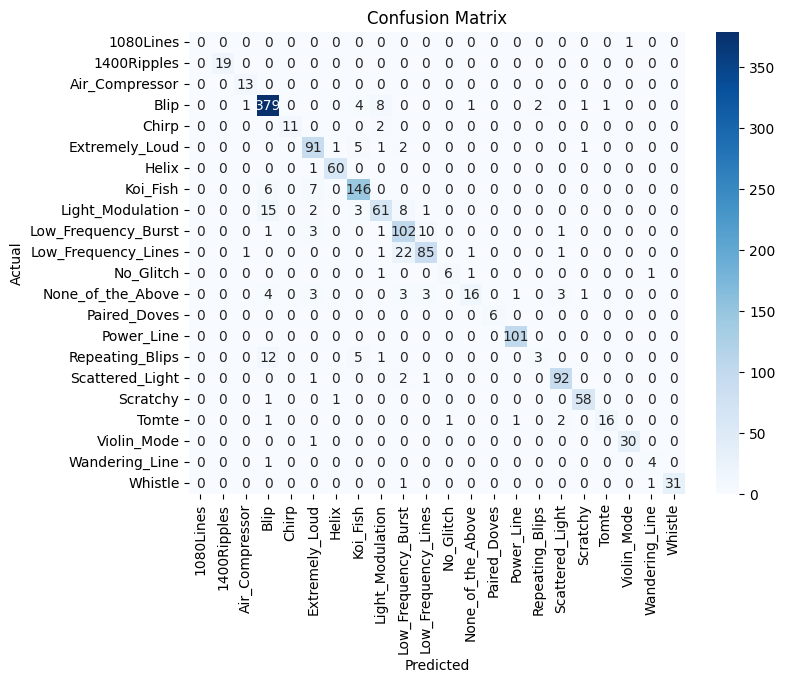

<Figure size 640x480 with 0 Axes>

In [42]:
#Dropping bandwidth
X = df2encoded.drop(["Type","bandwidth"],axis=1)
y = df2encoded["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=50)
clf = RandomForestClassifier(criterion= 'entropy', max_depth= 22, min_samples_split= 2, n_estimators= 110,random_state=50) 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f'Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix with class names using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=array_all_glitch_types, yticklabels=array_all_glitch_types)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig("confusion matrix.png")


In [17]:
#Dropping bandwidth Decision Tree Logistic
X = df2encoded.drop(["Type","bandwidth"],axis=1)
y = df2encoded["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=50)
clf = linear_model.LogisticRegression(multi_class='multinomial',C=10, max_iter= 1000, penalty='l2', solver= 'newton-cg',random_state=50)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f'Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')

Precision: 0.3033503935771748 | Recall: 0.318209250430807 | F-measure: 0.29931000401935176



In [21]:
#Dropping bandwidth Decision Tree KNN
X = df2encoded.drop(["Type","bandwidth"],axis=1)
y = df2encoded["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=50)
clf = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 3, weights='distance')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f'Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')

Precision: 0.46127635553169327 | Recall: 0.48683463620737116 | F-measure: 0.47000327879439924



## Encoding the test data to same form as train data

In [14]:
import category_encoders as ce
encoder=ce.OneHotEncoder(cols='ifo',use_cat_names=True)

tstdata=pd.read_csv('glitch_tst_data.csv')
test_ids = tstdata['id']
# Apply one-hot encoding
test_encoded = encoder.fit_transform(tstdata)

temp_column = test_encoded['ifo_H1'].copy()  
test_encoded['ifo_H1'] = test_encoded['ifo_L1']  
test_encoded['ifo_L1'] = temp_column
# print(test_encoded.head())

test_encoded = test_encoded.rename(columns={'ifo_H1': 'ifo_L1','ifo_L1': 'ifo_H1'})
# df2encoded = df2encoded.rename(columns={'ifo_L1': 'ifo_H1'})
test_encoded=test_encoded.drop(["bandwidth","id"],axis=1)
# print(test_encoded)

In [15]:
test_encoded

,GPStime,centralFreq,peakFreq,snr,ifo_L1,ifo_H1,duration
0,1.132261e+09,2960.810,38.027,63.400,0,1,2.000
1,1.132725e+09,1119.993,324.754,11.789,0,1,0.070
2,1.128422e+09,236.863,134.965,8.000,1,0,0.047
3,1.132886e+09,1905.332,137.711,14.362,0,1,0.125
4,1.132755e+09,1119.433,170.654,9.087,0,1,0.230
...,...,...,...,...,...,...,...
662,1.131064e+09,3698.458,89.676,83.563,0,1,1.597
663,1.128389e+09,158.524,134.965,7.943,1,0,0.039
664,1.134483e+09,1853.202,20.755,11.217,0,1,2.000
665,1.129802e+09,1818.097,2025.310,17.042,0,1,0.088


In [30]:
tstdata=pd.read_csv('glitch_tst_data.csv')
test_ids = tstdata['id']

In [53]:
df2encoded

,GPStime,centralFreq,peakFreq,snr,ifo_L1,ifo_H1,bandwidth,duration,Type
0,1.129517e+09,364.822,225.349,35.919,1,0,665.643311,0.250,Blip
1,1.135647e+09,3609.954,38.027,2743.555,0,1,7209.994629,13.690,Extremely_Loud
2,1.129802e+09,1838.466,2025.310,16.698,0,1,3612.932861,0.375,Violin_Mode
3,1.131774e+09,2067.878,111.128,12.727,0,1,4067.436523,0.105,Blip
4,1.130969e+09,3978.111,131.921,10.926,1,0,7795.106934,2.304,Scratchy
...,...,...,...,...,...,...,...,...,...
5995,1.137220e+09,1751.744,1527.022,13.545,1,0,1479.296509,0.070,1400Ripples
5996,1.135179e+09,2434.358,10.501,12.226,1,0,4856.431641,2.750,Low_Frequency_Burst
5997,1.133291e+09,2081.403,32.397,15.342,0,1,4118.316895,2.148,Scattered_Light
5998,1.132813e+09,458.770,402.439,9.298,0,1,787.527283,0.039,Blip


In [18]:
X = df2encoded.drop(["Type","bandwidth"],axis=1)
y = df2encoded["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=50)

rf_classifier = RandomForestClassifier(criterion= 'entropy', max_depth= 21, min_samples_split= 2, n_estimators= 130,random_state=50)
rf_adaboost = AdaBoostClassifier(rf_classifier, n_estimators=50, random_state=42)
rf_adaboost.fit(X_train, y_train)
y_rf_pred = rf_adaboost.predict(X_test)

precision, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_rf_pred, average='macro')
print(f'After Adaboost Model on random forest: | Precision: {precision} | Recall: {recall} | F-measure: {f_measure}\n')

predictions=rf_adaboost.predict(test_encoded)
results_df = pd.DataFrame({'id': test_ids, 'predicted_class': predictions})


After Adaboost Model on random forest: | Precision: 0.8612936970550009 | Recall: 0.7950703245021858 | F-measure: 0.8154098125558611



C:\Users\dpsat\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


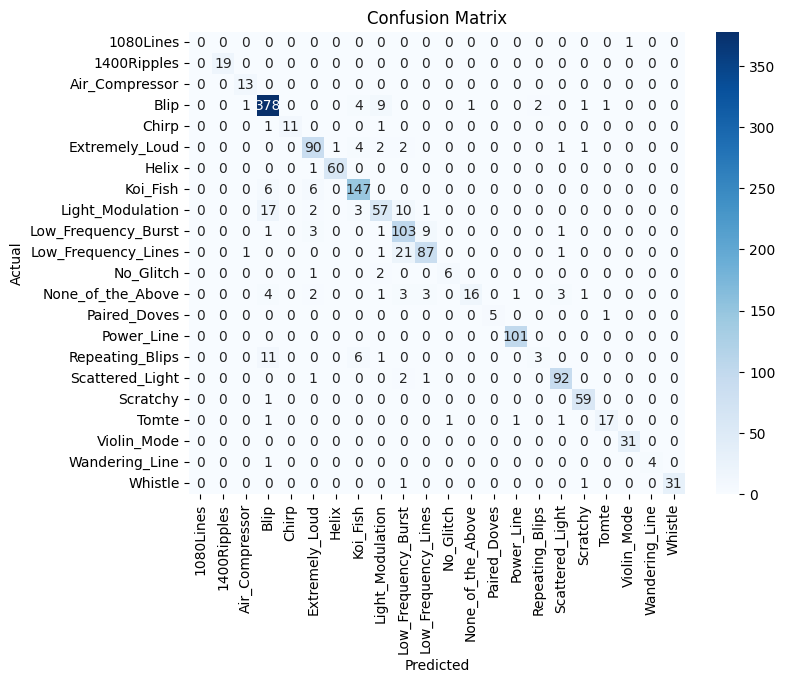

<Figure size 640x480 with 0 Axes>

In [21]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_rf_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=array_all_glitch_types, yticklabels=array_all_glitch_types)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig("confusion matrix.png")

In [22]:

results_df.to_csv('my_dataframe.csv', index=True)
results_df

,id,predicted_class
0,YVnrMXRcUP,Koi_Fish
1,qD8uxo1Jeu,Blip
2,Z5grpD4TOG,Helix
3,4TskgvMLa2,Blip
4,ZMEZmAs4gO,Blip
...,...,...
662,UWwq1ojfrU,Koi_Fish
663,OPltjycZFB,Helix
664,LFtvutSUqH,Scattered_Light
665,cQl1WTd8Sb,Violin_Mode


In [60]:
results_df["predicted_class"].value_counts()

predicted_class
Blip                   183
Koi_Fish                77
Low_Frequency_Burst     63
Low_Frequency_Lines     48
Power_Line              46
Scattered_Light         43
Extremely_Loud          42
Light_Modulation        34
Helix                   28
Scratchy                27
Violin_Mode             14
Whistle                 14
None_of_the_Above       11
Tomte                   10
1400Ripples              8
Air_Compressor           6
Chirp                    4
No_Glitch                3
Paired_Doves             3
Wandering_Line           3
Name: count, dtype: int64

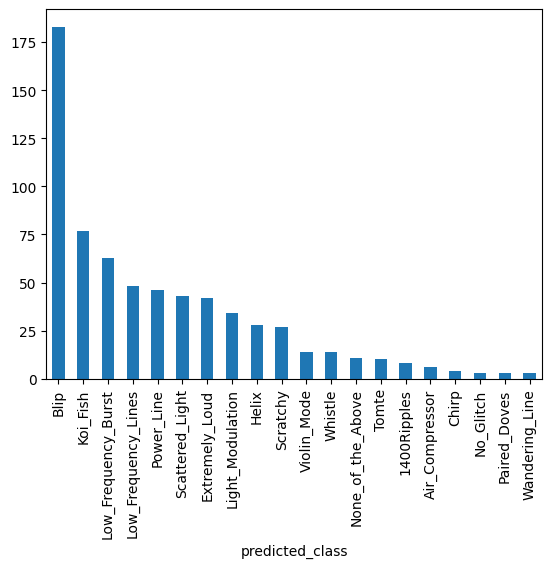

In [61]:
results_df["predicted_class"].value_counts().plot(kind="bar")
plt.savefig("glitch distribution test adaboost forest.png", bbox_inches='tight', facecolor='w')

In [24]:
results_df

,id,predicted_class
0,YVnrMXRcUP,Koi_Fish
1,qD8uxo1Jeu,Blip
2,Z5grpD4TOG,Helix
3,4TskgvMLa2,Blip
4,ZMEZmAs4gO,Blip
...,...,...
662,UWwq1ojfrU,Koi_Fish
663,OPltjycZFB,Helix
664,LFtvutSUqH,Scattered_Light
665,cQl1WTd8Sb,Violin_Mode


In [25]:
with open('cluster_labels.txt', 'w') as label_file:
    for label in predictions:
        label_file.write(str(label) + '\n')